In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from scipy.stats import lognorm, norm, t, pareto
import sys

sys.path.append('../')
from src.stats import *
from src.distributions import hypsecant2, double_pareto
from src.figures import *

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
sns.set_style('darkgrid')

%matplotlib inline

# 5.0 A borderline probability distribution?

## The "squared" hyperbolic secant distribtuion

To validate it is a subexponential distribution, we need to use the property of tanh:
$$\tanh (2x) = \frac{2\tanh x}{1+ \tanh^2 x }$$
and get
\begin{align*}
\lim_{x \to +\infty} \frac{F(x)^2}{F(2x)} &= \lim_{x \to +\infty} \frac{\left(\frac{1}{2} (1 - \tanh(kx))\right)^2}{\frac{1}{2} (1 - \tanh(2kx))} \\
&= \lim_{x \to +\infty} \frac{(1 - \tanh(kx))^2}{2(1 - \tanh(2kx))} \\
&= \lim_{x \to +\infty} \frac{(1 - \tanh(kx))^2}{2(1 - \frac{2\tanh(kx)}{1+ \tanh^2(kx)})} \\
&= \lim_{y \to 1} \frac{(1 + y^2)}{2} = 1
\end{align*}
where $y = \tanh(kx)$

From which the pdf reads
$$
f(x) = \frac{1}{2}k \cdot \mathrm{sech}^2(kx)
$$
It is actually the square of the [hyperbolic secant distribution](https://en.wikipedia.org/wiki/Hyperbolic_secant_distribution).

Figure below validates the pdf, chf and ppf (for random numbers)

C:\Users\soars\Documents\Github\Technical-Incerto-Python\1 - Statistical Consequences of Fat Tails\..\src\stats.py:49: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sinh(x)
C:\Users\soars\Documents\Github\Technical-Incerto-Python\1 - Statistical Consequences of Fat Tails\..\src\distributions.py:75: RuntimeWarning: invalid value encountered in multiply
  return (np.pi * x * csch(np.pi * x * scale / 2)) * scale / 2


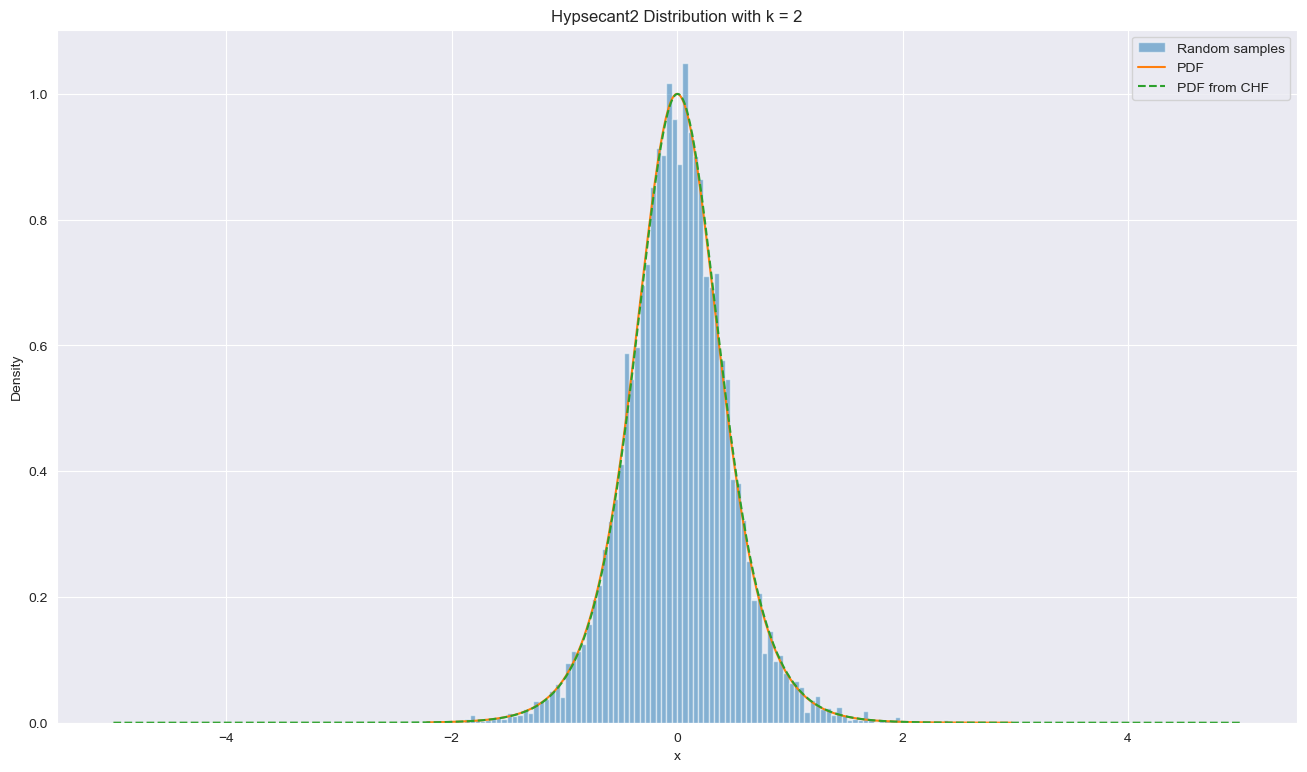

In [2]:
# Set parameters
k = 2
x_min = -5
x_max = 5
n = 1000

#  Evaluate the PDF and overlay it on the histogram
fig, ax = plt.subplots(figsize=(16, 9))
plot_pdf_hist(hypsecant2, ax, loc=0, scale=1/k)

# Evaluate the PDF from the CHF and plot it with a dashed line on the same axes
x, pdf_from_chf = chf_to_pdf(lambda x: hypsecant2.chf(x, loc=0, scale=1/k), x_min, x_max, n)
ax.plot(x, pdf_from_chf, '--', label='PDF from CHF')

# Set plot title, x-axis label, and y-axis label
ax.set_title('Hypsecant2 Distribution with k = 2')
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.legend()
plt.show()

## The ratio of survival functions

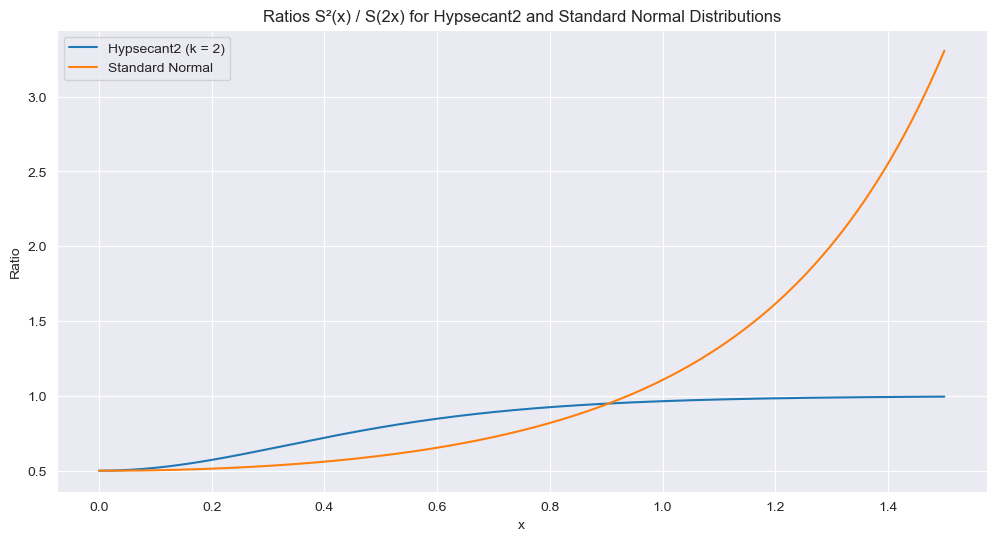

In [3]:
# Set the x range
x_values = np.linspace(0, 1.5, 1000)

# Calculate the ratios for the Hypsecant2 distribution
k = 2
hs2_ratios = hypsecant2.sf(x_values, scale=1/k)**2 / hypsecant2.sf(2 * x_values, scale=1/k)

# Calculate the ratios for the standard normal distribution
normal_ratios = norm.sf(x_values)**2 / norm.sf(2 * x_values)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_values, hs2_ratios, label='Hypsecant2 (k = 2)')
ax.plot(x_values, normal_ratios, label='Standard Normal')

# Set plot title, x-axis label, and y-axis label
ax.set_title('Ratios S²(x) / S(2x) for Hypsecant2 and Standard Normal Distributions')
ax.set_xlabel('x')
ax.set_ylabel('Ratio')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()


# 5.1 level 3: scalability and power laws

## Figure 5.2: Three Types of Distributions

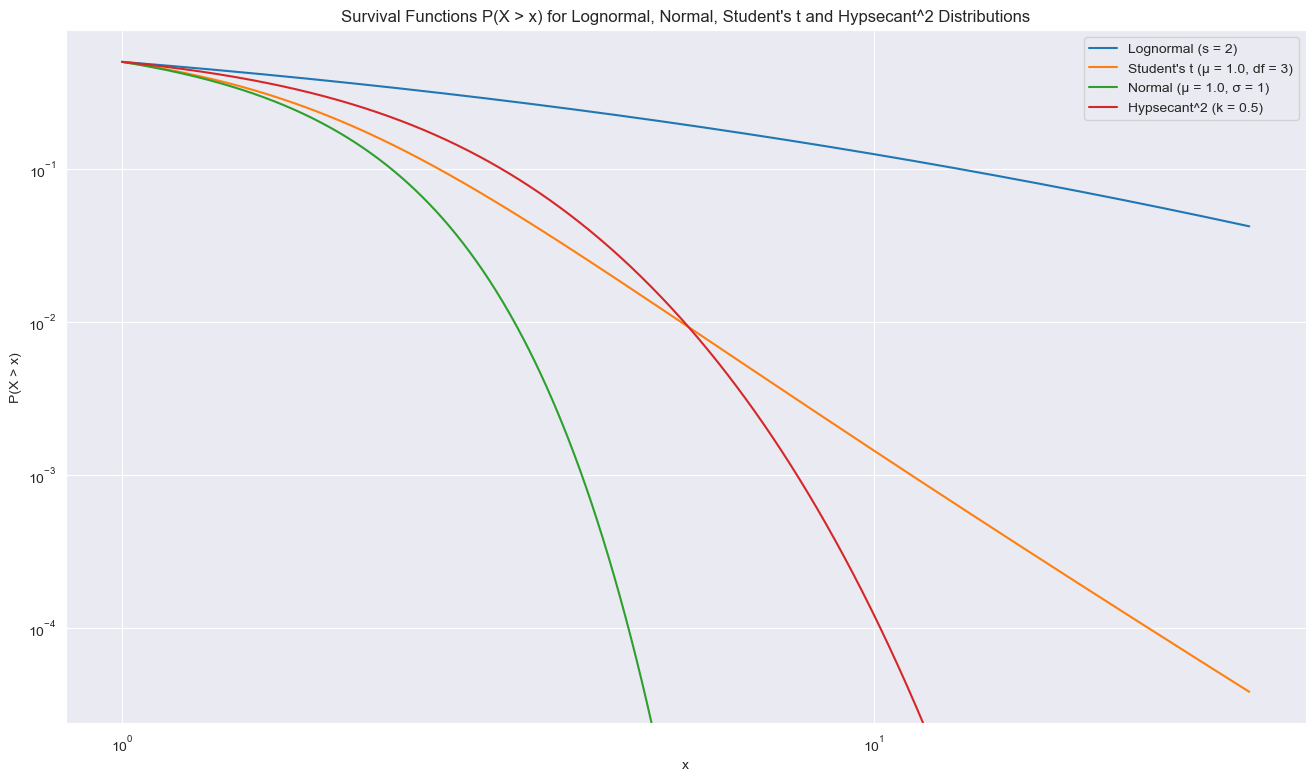

In [4]:
# Set the parameters for the distributions
logn_mu = 0
logn_sigma = 2      # Shape parameter for the lognormal distribution
logn_median = np.exp(logn_mu)
norm_sigma = 1  # Standard deviation for the normal distribution
t_df = 3   # Degrees of freedom for the Student's t distribution
k = 0.5

# Set the x range (log scale) from 10^-4 to 10^1
x = np.logspace(np.log10(logn_median), 1.5, 1000)

# Calculate the survival functions for each distribution
logn_sf = lognorm.sf(x, logn_sigma, loc=logn_mu)
normal_sf = norm.sf(x, loc=logn_median, scale=norm_sigma)
t_sf = t.sf(x, loc=logn_median, df=t_df)
hyp_sf = hypsecant2.sf(x, loc=logn_median, scale=1/k) 

# Create the plot
fig, ax = plt.subplots(figsize=(16, 9))

# Set the x and y axes to log scale
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(x, logn_sf, label='Lognormal (s = {})'.format(logn_sigma))
ax.plot(x, t_sf, label="Student's t (µ = {}, df = {})".format(logn_median, t_df))

# normal_sf would be too small on log-y axis, this is to fix the y range
ylim = ax.get_ylim()
ax.plot(x, normal_sf, label='Normal (µ = {}, σ = {})'.format(logn_median, norm_sigma))
ax.plot(x, hyp_sf, label="Hypsecant^2 (k = {})".format(k))
ax.set_ylim(ylim)

# Set plot title, x-axis label, and y-axis label
ax.set_title('Survival Functions P(X > x) for Lognormal, Normal, Student\'s t and Hypsecant^2 Distributions')
ax.set_xlabel('x')
ax.set_ylabel('P(X > x)')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()


## Figure 5.3: The "Grey Swan" of Brexit

We fit the (log) empirical survival function by linear regression to estimate the power law parameter $\alpha$:
$$P(X>x) \sim C e^{-\alpha}$$
$$\log P(X>x) \approx \log C - \alpha \log(x)$$
See details in `PowerLawEmpirical`.

Text(0, 0.5, 'P(X > x)')

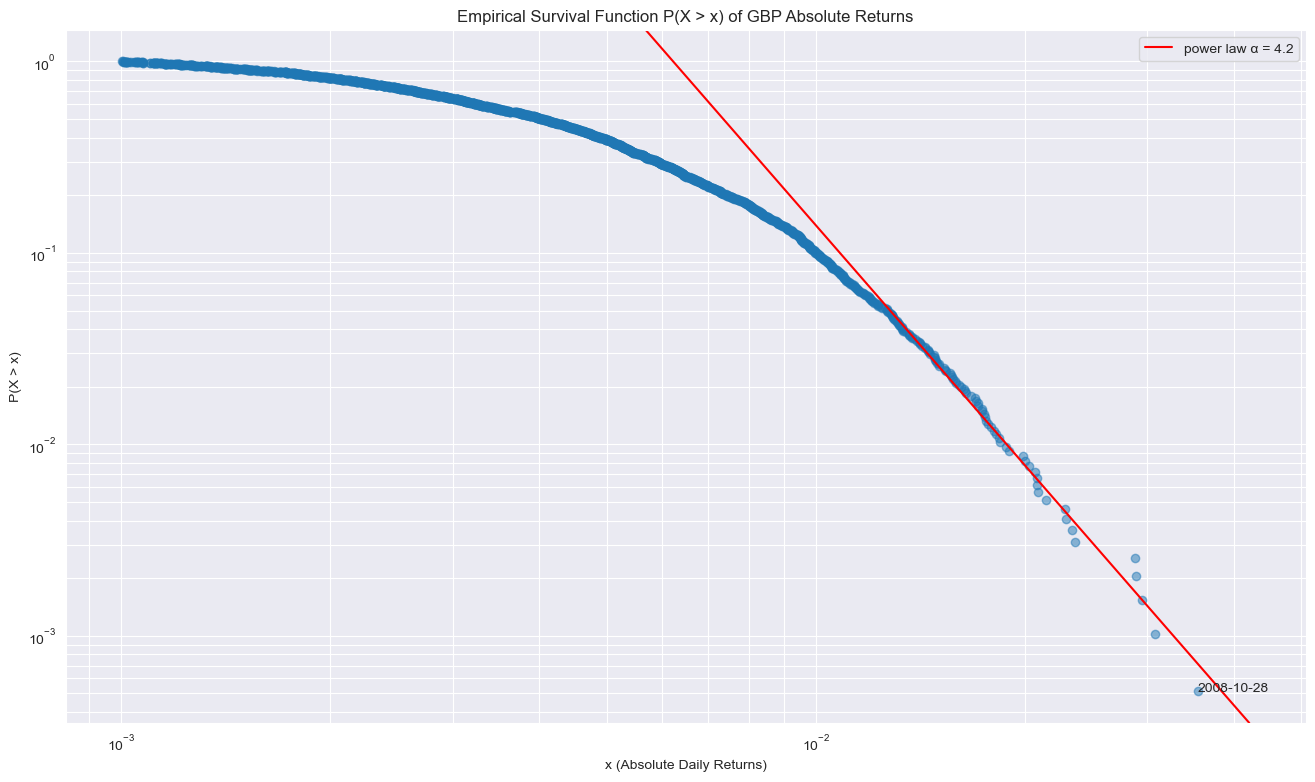

In [5]:
# Data source: Yahoo Finance
gbp_data = pd.read_csv('../data/GBP.csv', index_col=0, parse_dates=True)
gbp_data['Return'] = gbp_data['Adj Close'].pct_change().dropna()
gbp_data = gbp_data.loc[gbp_data['Return']>0.001]
grey_swan_date = gbp_data['Return'].abs().idxmax().strftime('%Y-%m-%d')

pl = PowerLawEmpirical().fit(gbp_data['Return'].abs())

fig, ax = plt.subplots(figsize=(16, 9))
pl.loglog_plot(ax=ax)
ax.text(pl.x[-1], pl.sf[-1], grey_swan_date)
ax.set_title('Empirical Survival Function P(X > x) of GBP Absolute Returns')
ax.set_xlabel('x (Absolute Daily Returns)')
ax.set_ylabel('P(X > x)')

Text(0, 0.5, 'P(X > x)')

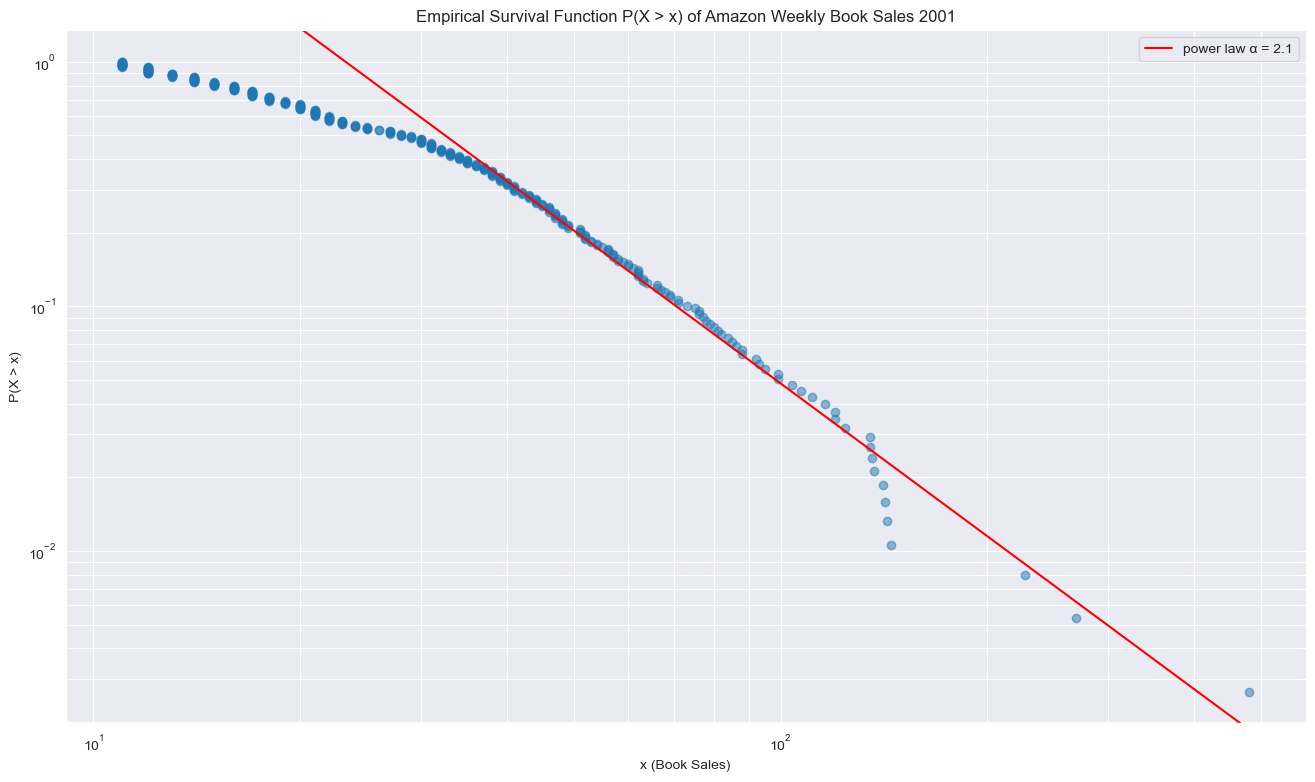

In [6]:
# Data source: https://www.kaggle.com/datasets/yuanmozhu/amazon-book-sales-vs-rank
book_sales = pd.read_csv('../data/AmazonBookRank2001.csv')
book_sales = book_sales.loc[book_sales['Weekly Sales']>10]
pl = PowerLawEmpirical().fit(book_sales['Weekly Sales'].dropna())

fig, ax = plt.subplots(figsize=(16, 9))
pl.loglog_plot(ax=ax)
ax.legend()
ax.set_title('Empirical Survival Function P(X > x) of Amazon Weekly Book Sales 2001')
ax.set_xlabel('x (Book Sales)')
ax.set_ylabel('P(X > x)')

Text(0, 0.5, 'P(X > x)')

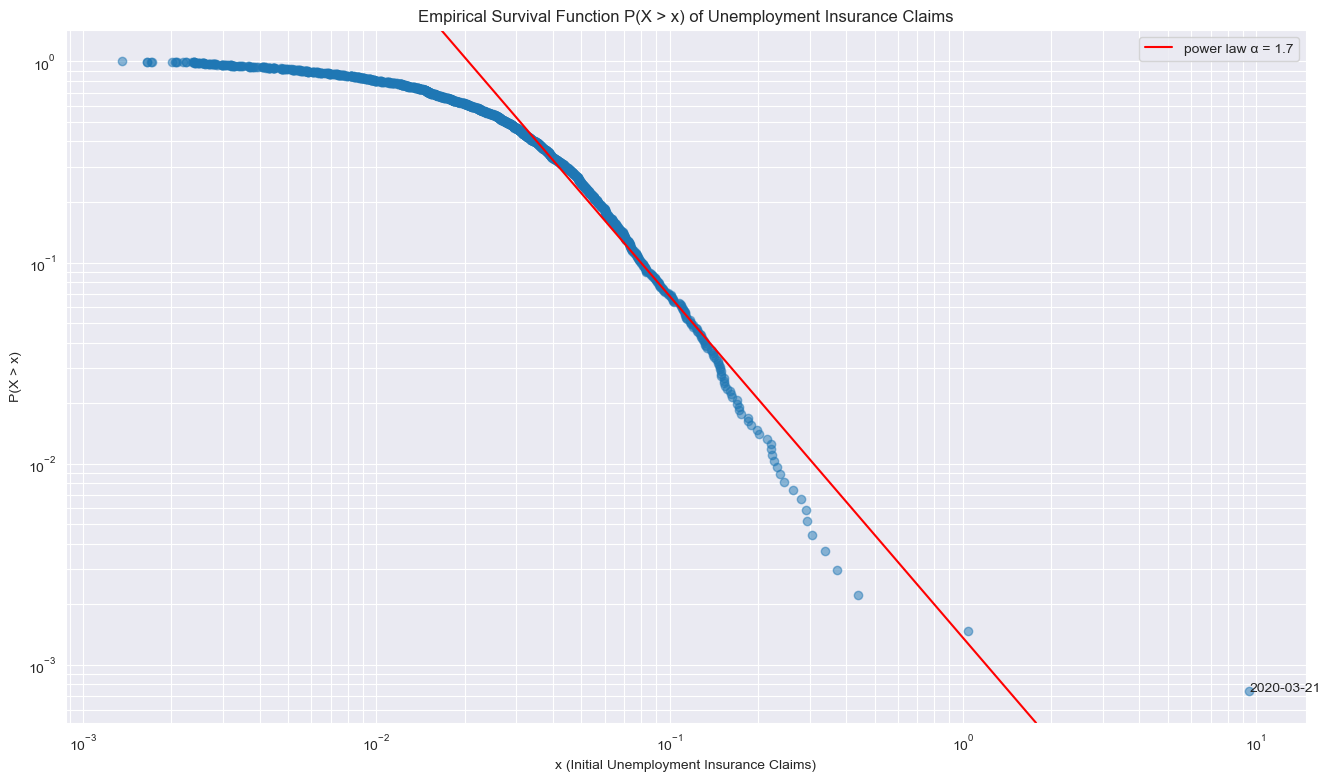

In [7]:
# Data source: https://oui.doleta.gov/unemploy/claims.asp
initial_claims = pd.read_csv('../data/SeasonallyAdjustedInitialClaims.csv', index_col=0, parse_dates=True)
x = initial_claims['Initial Claims'].pct_change().dropna()
grey_swan_date = x.abs().idxmax().strftime('%Y-%m-%d')

pl = PowerLawEmpirical().fit(x)

fig, ax = plt.subplots(figsize=(16, 9))
pl.loglog_plot(ax=ax)
ax.text(pl.x[-1], pl.sf[-1], grey_swan_date)
ax.legend()
ax.set_title('Empirical Survival Function P(X > x) of Unemployment Insurance Claims')
ax.set_xlabel('x (Initial Unemployment Insurance Claims)')
ax.set_ylabel('P(X > x)')

Text(0, 0.5, 'P(X > x)')

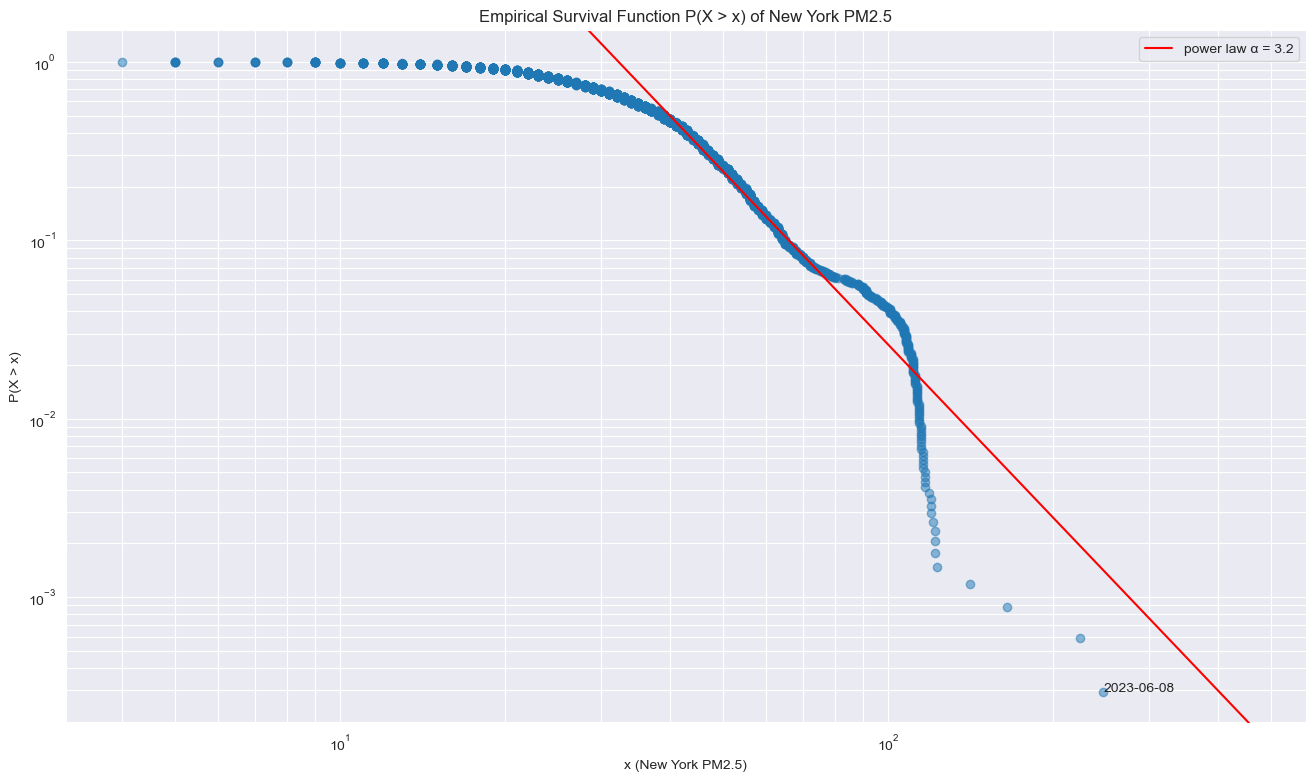

In [49]:
air_quality = pd.read_csv('../data/new-york-air-quality.csv', index_col=0, parse_dates=True)
air_quality.columns = air_quality.columns.str.replace(' ', '')
def text_to_number(s):
    try:
        return float(s.replace(' ', ''))
    except:
        return np.nan
for c in air_quality.columns:
    air_quality[c] = air_quality[c].apply(text_to_number).astype(float)

x = air_quality['pm25'].sort_index().dropna()
grey_swan_date = x.abs().idxmax().strftime('%Y-%m-%d')

pl = PowerLawEmpirical().fit(x)

fig, ax = plt.subplots(figsize=(16, 9))
pl.loglog_plot(ax=ax)
ax.text(pl.x[-1], pl.sf[-1], grey_swan_date)
ax.legend()
ax.set_title('Empirical Survival Function P(X > x) of New York PM2.5')
ax.set_xlabel('x (New York PM2.5)')
ax.set_ylabel('P(X > x)')

<Axes: >

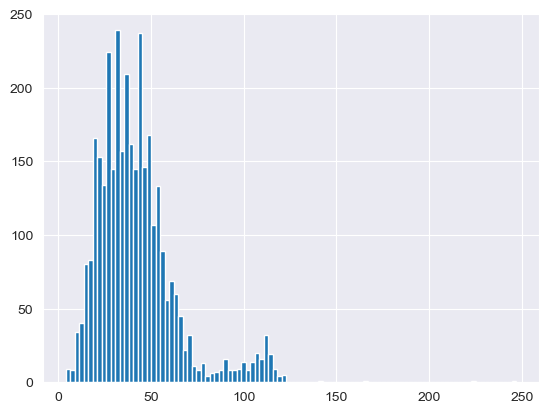

In [46]:
air_quality['pm25'].hist(bins=100)

In [45]:
x
    

array([-0.72578165,  1.48726554, -0.63371757, ...,  1.71851241,
        1.16288834, -0.21826411])

In [13]:
air_quality = pd.read_csv('../data/new-york-air-quality.csv', index_col=0, parse_dates=True)


KeyError: 'pm25'

# 5.2 some properties of power laws

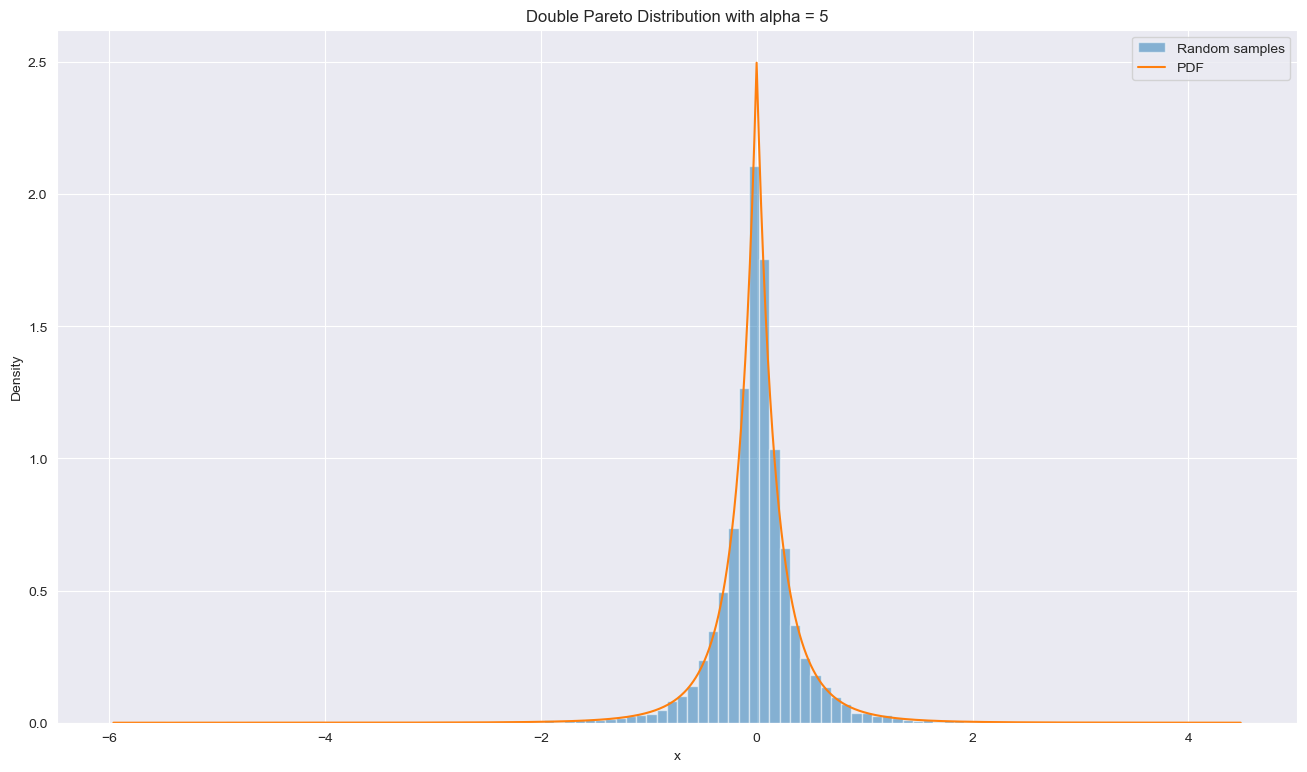

In [8]:
# Set parameters
alpha = 5

#  Evaluate the PDF and overlay it on the histogram
fig, ax = plt.subplots(figsize=(16, 9))
plot_pdf_hist(double_pareto, ax, alpha=alpha, loc=0, scale=1)

# Set plot title, x-axis label, and y-axis label
ax.set_title('Double Pareto Distribution with alpha = {}'.format(alpha))
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.legend()
plt.show()